In [26]:
# Loading necessary libraries: 

import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re



In [2]:
# Reading the csv file: 

news = pd.read_csv('/Users/samreade/Desktop/COMM 188C/news_AP.csv')

In [3]:
# Previewing the data: 

news.head()

,title,topic
0,Terminally ill Connecticut woman ends her life...,Healthcare
1,King Charles III will have a prostate operatio...,Healthcare
2,Community health centers serve 1 in 11 America...,Healthcare
3,Washington state reaches a nearly $150 million...,Healthcare
4,Community health centers serve 1 in 11 America...,Healthcare


In [4]:
# Checking unique values for topic:

news['topic'].unique()

array(['Healthcare', 'Sports - Football', 'Animals', 'Transportation'],
      dtype=object)

In [5]:
# Making data frame for the 'title' column: 

titles = news['title']
titles 

0      Terminally ill Connecticut woman ends her life...
1      King Charles III will have a prostate operatio...
2      Community health centers serve 1 in 11 America...
3      Washington state reaches a nearly $150 million...
4      Community health centers serve 1 in 11 America...
                             ...                        
194    No joke: Feds discourage humorous electronic m...
195    A timeline of key moments leading to Japan pla...
196    Federal officials order grounding of some Boei...
197    What you should know if you're about to fly on...
198    Taylor Drift or Beyonsleigh? Voting open to na...
Name: title, Length: 199, dtype: object

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samreade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Function for preprocessing: 

def preprocess_texts(texts):
    
    cleaned = [re.sub(r'[^\w\s]', '', t.lower()) for t in texts]

    tokenized = [[word for word in t.split() if word not in stop_words] for t in cleaned]

    all_words = [word for sublist in tokenized for word in sublist]
    word_counts = Counter(all_words)
    tokenized = [[word for word in tokens if word_counts[word] > 1] for tokens in tokenized]

    preprocessed_texts = [' '.join(tokens) for tokens in tokenized]
    return preprocessed_texts 


In [8]:
preprocessed_titles = preprocess_texts(news['title'])   

In [9]:
# Vectorizing with tfidf:

vectorizer = TfidfVectorizer() 
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)

print(titles_tfidf.shape)  
print(titles_tfidf.toarray()) 

(199, 441)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.32230679 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [10]:
# Splitting testing and training data: 

target = news['topic']  

X_train, X_test, y_train, y_test = train_test_split(
    titles_tfidf, target, test_size=0.2, random_state=42, stratify=target 
)


In [11]:
# Defining the parameter grid:

par_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

# Initializing the Random Forest:

forest = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with 5-fold cross-validation

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=par_grid,
    cv=5,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2
)

# Fitting to the training data: 

grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [12]:
# Reviewing Cross Validation: 

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res = cv_res[['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score']]
print(cv_res.sort_values(by='mean_test_score', ascending=False))


  param_n_estimators param_max_depth  mean_test_score  std_test_score
7                100            None         0.823992        0.024316
8                200            None         0.805040        0.023186
6                 50            None         0.792742        0.045725
4                100              20         0.736089        0.035927
5                200              20         0.736089        0.049625
3                 50              20         0.723589        0.039597
2                200              10         0.654234        0.064708
1                100              10         0.647984        0.062670
0                 50              10         0.641734        0.063091


In [13]:
# Accessing best model:

best_mod = grid_search.best_estimator_


In [14]:
# Predicting on the test set: 

prediction = best_mod.predict(X_test) 

In [15]:
# Precision, recall, F1:

report = classification_report(y_test, prediction, digits=4)
print("Classification Report:\n", report) 

# Accuracy

accuracy = accuracy_score(y_test, prediction)
print(f"Overall Accuracy: {accuracy:.4f}")

Classification Report:
                    precision    recall  f1-score   support

          Animals     0.8333    1.0000    0.9091        10
       Healthcare     1.0000    0.8333    0.9091         6
Sports - Football     1.0000    0.9375    0.9677        16
   Transportation     1.0000    1.0000    1.0000         8

         accuracy                         0.9500        40
        macro avg     0.9583    0.9427    0.9465        40
     weighted avg     0.9583    0.9500    0.9507        40

Overall Accuracy: 0.9500


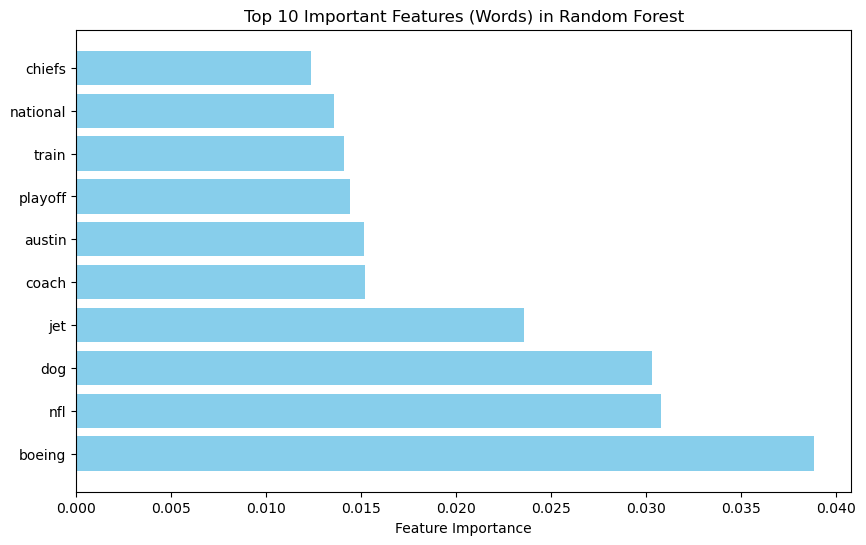

In [16]:
# Visualizing feature importance: 

importances = best_mod.feature_importances_

feature_names = vectorizer.get_feature_names_out() 

indices = np.argsort(importances)[::-1]

top_n = 10
top_feat = feature_names[indices[:top_n]]
top_import = importances[indices[:top_n]]

# Plotting: 

plt.figure(figsize=(10,6))
plt.barh(range(top_n), top_import[::-1], align='center', color='skyblue')
plt.yticks(range(top_n), top_feat[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features (Words) in Random Forest')
plt.gca().invert_yaxis()  
plt.show() 


In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')

titles_embed = model.encode(titles)

print(titles_embed.shape)  
print(titles_embed[0])     

(199, 384)
[-2.44639833e-02 -1.43329110e-02  4.41281274e-02 -1.10135255e-02
  2.51884796e-02  5.03598414e-02 -7.07518011e-02  1.71091594e-02
 -1.03660794e-02  8.67259800e-02  2.92921793e-02  4.23028953e-02
 -4.44466174e-02 -5.34491539e-02 -4.92200777e-02  7.37725720e-02
 -9.33739990e-02 -2.32482720e-02 -1.35441395e-02  1.63757443e-01
  4.00544219e-02  4.77173813e-02  4.04412713e-04  2.37355996e-02
  2.61475239e-02  2.13943962e-02 -1.25460969e-02 -2.66241357e-02
  8.39642901e-03  6.66567534e-02 -4.21962179e-02  6.31326670e-03
 -3.34085822e-02 -7.14927586e-03  1.77836828e-02  1.13129308e-02
 -2.50684433e-02  5.97392768e-02 -6.91123679e-03  3.43728215e-02
 -3.33238370e-03  3.75055596e-02  4.93241511e-02  3.76770571e-02
 -2.55402271e-03 -7.81035796e-02 -4.44835573e-02 -3.14558558e-02
  1.63568594e-02  4.69642924e-03  2.34670565e-02 -3.61010456e-03
 -2.72163339e-02  5.90672567e-02  9.42404906e-04 -3.87796247e-03
  6.33248826e-03 -3.71260643e-02 -4.47440296e-02  1.98937692e-02
  2.01524571e-

In [18]:
# Splitting using same target: 

X_train2, X_test2, y_train, y_test = train_test_split(
    titles_embed, target, test_size=0.2, random_state=42, stratify=target 
)

In [19]:
# Defining the parameter grid:

par_grid2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

# Initializing the Random Forest:

forest2 = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with 5-fold cross-validation

grid_search2 = GridSearchCV(
    estimator=forest2,
    param_grid=par_grid2,
    cv=5,  
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2
)

# Fitting to the training data: 

grid_search2.fit(X_train2, y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=10, n_est

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [20]:
# Reviewing Cross Validation: 

cv_res2 = pd.DataFrame(grid_search2.cv_results_)
cv_res2 = cv_res2[['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score']]
print(cv_res2.sort_values(by='mean_test_score', ascending=False))


  param_n_estimators param_max_depth  mean_test_score  std_test_score
2                200              10          0.93125        0.045928
5                200              20          0.93125        0.045928
8                200            None          0.93125        0.045928
0                 50              10          0.91875        0.057960
3                 50              20          0.91875        0.057960
6                 50            None          0.91875        0.057960
1                100              10          0.90625        0.065551
4                100              20          0.90625        0.065551
7                100            None          0.90625        0.065551


In [21]:
# Accessing best model:

best_mod2 = grid_search2.best_estimator_


In [22]:
# Predicting on the test set: 

prediction2 = best_mod2.predict(X_test2) 

In [23]:
# Precision, recall, F1:

report2 = classification_report(y_test, prediction2, digits=4)
print("Classification Report:\n", report2) 

# Accuracy

accuracy2 = accuracy_score(y_test, prediction2)
print(f"Overall Accuracy: {accuracy2:.4f}")

Classification Report:
                    precision    recall  f1-score   support

          Animals     1.0000    0.8000    0.8889        10
       Healthcare     1.0000    0.8333    0.9091         6
Sports - Football     0.8889    1.0000    0.9412        16
   Transportation     0.8889    1.0000    0.9412         8

         accuracy                         0.9250        40
        macro avg     0.9444    0.9083    0.9201        40
     weighted avg     0.9333    0.9250    0.9233        40

Overall Accuracy: 0.9250


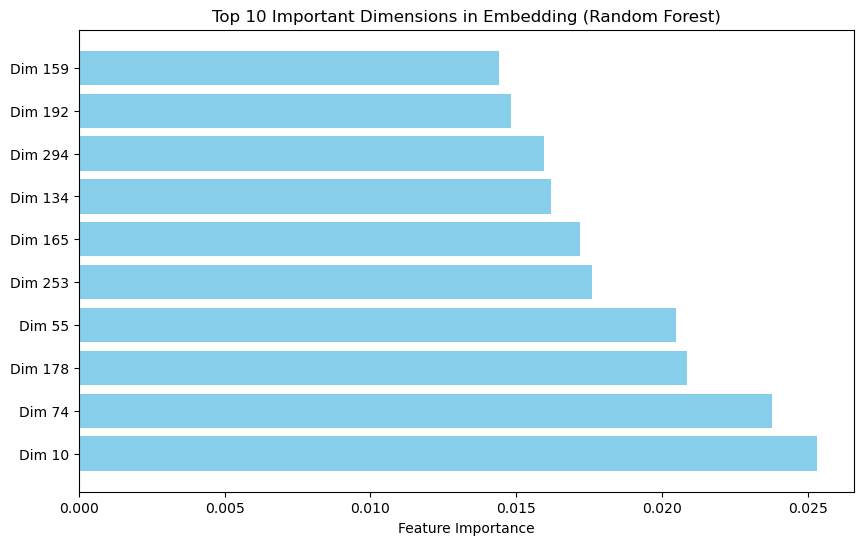

In [29]:
# Visualizing feature importance: 

importances2 = best_mod2.feature_importances_
indices2 = np.argsort(importances2)[::-1]

top_n = 10
top_dims = [f"Dim {i}" for i in indices2[:top_n]]
top_importances = importances2[indices2[:top_n]]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], color='skyblue')
plt.yticks(range(top_n), top_dims[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Dimensions in Embedding (Random Forest)')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Comparison between TF-IDF and Sentence Embeddings for Random Forest: 

# The TF-IDF based model outperformed the embedding based model across nearly all evaluation metrics. It achieved an overall accuracy of 95%, compared 
# to 92.5% for the embedding model. The TF-IDF model also had a higher macro-averaged precision, 0.9583 vs. 0.9444, recall, 0.9427 vs. 0.9083, 
# and F1-score, 0.9465 vs. 0.9201. At the class level, the TF-IDF model performed particularly well on the “Transportation” and “Sports - Football” 
# categories, achieving perfect or near-perfect scores. The embeddings still produced good results and may generalize better in more complex 
# contexts. The sparse TF-IDF representation proved more effective on this particular dataset of short news headlines. 

In [ ]:
# Comparing unsupervised approach vs. supervised: 

# The supervised approach was far more effective than the unsupervised approach. The average accuracy for the supervised approaches was 93.75%, while
# the average accuracy for the unsupervised approach was only 37.94%. Overall, the supervised Random Forest approach was much more effective than the 
# unsupervised k-means clustering approach. 

In [27]:
# Trying feature selection: 

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)


selector = SelectFromModel(rf_selector, threshold="median", prefit=True)

X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Reduced shape:  {X_train_reduced.shape}")

Original shape: (159, 441)
Reduced shape:  (159, 221)


In [28]:
# Retraining and evaluating: 

rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = rf_reduced.predict(X_test_reduced)

print("Classification Report (Reduced Features):")
print(classification_report(y_test, y_pred_reduced))
print("Accuracy:", accuracy_score(y_test, y_pred_reduced))


Classification Report (Reduced Features):
                   precision    recall  f1-score   support

          Animals       0.67      1.00      0.80        10
       Healthcare       1.00      0.83      0.91         6
Sports - Football       1.00      0.88      0.93        16
   Transportation       1.00      0.75      0.86         8

         accuracy                           0.88        40
        macro avg       0.92      0.86      0.87        40
     weighted avg       0.92      0.88      0.88        40

Accuracy: 0.875
